In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad, simps

from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
import warnings
from matplotlib.colors import LogNorm
warnings.filterwarnings('ignore')

In [3]:
path = "/data/OWN/DMO/mochima2/output_00041"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myDMO = wkbl.Galaxy_Hound(path)
print "centering"
zoom_reg = np.where(myDMO.dm.mass == myDMO.dm.mass.min())
nucenter = nbe.real_center(myDMO.dm.pos3d[zoom_reg], myDMO.dm.mass[zoom_reg])
myDMO.center_shift(nucenter)
myDMO.r_virial(600)
print "done r200 = {0}".format(myDMO.r200)
myDMO.redefine(2.5)


loading Dark matter..
centering
done r200 = 229.1015625


In [4]:
ok,myDMO.dm.rho,_= CF.getDensity(np.array(myDMO.dm.pos3d.reshape(len(myDMO.dm.pos3d)*3),dtype=np.float32), myDMO.dm.mass)

In [5]:
def abg_logprofile(x,p_s,r_s,al,be,ga):
    x = 10**x
    power =  (be - ga) / (al)
    denominator = ((x/(r_s))**ga) * ((1 + (x / (r_s))**al)**power)
    return np.log10(10**p_s / denominator)

In [6]:
def abg_profile(x,po,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return (10**po) / denominator

## calculate Power's radius

In [7]:
Pcrit = myDMO.dm._p.rho_crit
Mdm = myDMO.dm.mass.min()
myradiuses = myDMO.dm.r[np.argsort(myDMO.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]
print R_P03
hsml=  R_P03
# R array logarithmic Bining
r_p = np.logspace(np.log10(hsml),np.log10(2.5*myDMO.r200),100)
# histogram of dm particles per logarithmic bin
n_dm,r = np.histogram(myDMO.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
r_size = r_p[1:]-r_p[:-1]
# density per shell
profileDMO = n_dm*myDMO.dm.mass.min()/vol
# center of bins
r = (r_p[:-1]+r_p[1:])/2.
bin_size= (r_p[:-1]-r_p[1:])/2.
rr = r

# extra estatistics from Cfalcon density
mean = np.array([])
std = np.array([])
n=np.array([])
for i in range(len(r_p)-1):
    shell = np.where((myDMO.dm.r > r_p[i])&(myDMO.dm.r < r_p[i+1])&(myDMO.dm.r > hsml))
    n = np.append(n,len(shell[0]))
    mean = np.append(mean,np.mean(myDMO.dm.rho[shell]))
    std = np.append(std,np.std(myDMO.dm.rho[shell]))
    

m_obs = n_dm*myDMO.dm.mass.min()
n = np.array([len(myDMO.dm.mass[myDMO.dm.r<i]) for i in r]) 

1.96601130417


In [8]:


def chi2_mass(po,r_s,al,be,ga):
    def my_int(R):
        r_test = np.logspace(np.log10(hsml),np.log10(R),100)
        rho_test = 4* np.pi * (r_test**2) * abg_profile(r_test,po,r_s,al,be,ga)
        return simps(rho_test,r_test)
    expected = np.array([my_int(i) for i in r])
    c = (np.log10(m_obs)- np.log10(expected))/ (np.log10(m_obs)-0.5*np.log10(n))
    c = c**2
    return np.sum(c)

def chi2_mass_bin(po,r_s,al,be,ga):
    def my_int(Ri,Rf):
        r_test = np.logspace(np.log10(Ri),np.log10(Rf),100)
        rho_test =  (r_test**2) * abg_profile(r_test,po,r_s,al,be,ga)
        return 4* np.pi * simps(rho_test,r_test)
    expected = np.array([my_int(r_p[i],r_p[i+1]) for i in range(len(r))])
    c = (np.log10(m_obs)- np.log10(expected))#/ (np.log10(m_obs)-0.5*np.log10(n))
    c = c**2
    return np.sum(c)



def chi2_rho(po,r_s,al,be,ga):
    rho_obs = profileDMO
    rho_the = np.array([abg_profile(i,po,r_s,al,be,ga) for i in r])
    c = (np.log10(rho_the) - np.log10(rho_obs))/ np.log10(std)
    c = c**2
    return np.sum(c)

In [9]:

m_rho = Minuit(chi2_rho, 
         po=7.0,    error_po=0.01,  limit_po =(6.,11.),
         r_s=19.3,  error_r_s=0.1,   limit_r_s=(10.,22),
         al=1.,     error_al=0.01,   limit_al =(0.99,1.01),
         be=3.,     error_be=0.01,   limit_be =(2.5,3.5),
         ga=1.,     error_ga=0.01,   limit_ga =(.5,1.5))
m_rho.migrad();

FCN = 0.0132343604129 
 TOTAL NCALL = 131 
 NCALLS = 131 
 
 
 EDM = 7.92753757779e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 6.96433 
 3.90244 
 0 
 0 
 6.0 
 11.0 
 
 
 
 
 2 
 r_s 
 20.0943 
 6.45333 
 0 
 0 
 10.0 
 22.0 
 
 
 
 
 3 
 al 
 1.00423 
 0.0126771 
 0 
 0 
 0.99 
 1.01 
 
 
 
 
 4 
 be 
 3.20789 
 0.617382 
 0 
 0 
 2.5 
 3.5 
 
 
 
 
 5 
 ga 
 1.10188 
 0.605853 
 0 
 0 
 0.5 
 1.5 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 6.964e+00 & 3.902e+00 & & & 6.000e+00 & 1.100e+01 & \\
\hline
2 & $r_{s}$ & 2.009e+01 & 6.453e+00 & & & 1.000e+01 & 2.200e+01 & \\
\hline
3 & al & 1.004e+00 & 1.268e-02 & & & 9.900e-01 & 1.010e+00 & \\
\hline
4 & be & 3.208e+00 & 6.174e-01 & & & 2.500e+00 & 3.500e+00 & \\
\hline
5 & ga & 1.102e+00 & 6.059e-01 & & & 5.000e-01 & 1.500e+00 & \\
\hline
\end{tabular}

In [10]:
low = 0.9
upp = 1.1
po,r_s,al,be,ga = m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga']
m_SC = Minuit(chi2_mass, 
         po=po,    error_po=0.01,  limit_po =(po*low,po*upp),
         r_s=r_s,  error_r_s=1.,   limit_r_s=(r_s*low,r_s*upp),
         al=al,     error_al=0.1,   limit_al =(al*low,al*upp),
         be=be,     error_be=0.1,   limit_be =(be*low,be*upp),
         ga=ga,     error_ga=0.1,   limit_ga =(ga*low,ga*upp))
m_SC.migrad();

FCN = 0.270164129277 
 TOTAL NCALL = 139 
 NCALLS = 139 
 
 
 EDM = 0.000199266128632 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 6.26796 
 1.18746 
 0 
 0 
 6.26789451728 
 7.66075996556 
 
 
 
 
 2 
 r_s 
 18.0849 
 3.1804 
 0 
 0 
 18.0848812532 
 22.1037437539 
 
 
 
 
 3 
 al 
 0.903808 
 0.107562 
 0 
 0 
 0.903807775986 
 1.10465394843 
 
 
 
 
 4 
 be 
 3.52853 
 0.614282 
 0 
 0 
 2.88710287689 
 3.52868129397 
 
 
 
 
 5 
 ga 
 0.992974 
 0.218593 
 0 
 0 
 0.991695954537 
 1.21207283332 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 6.268e+00 & 1.187e+00 & & & 6.268e+00 & 7.661e+00 & \\
\hline
2 & $r_{s}$ & 1.808e+01 & 3.180e+00 & & & 1.808e+01 & 2.210e+01 & \\
\hline
3 & al & 9.038e-01 & 1.076e-01 & & & 9.038e-01 & 1.105e+00 & \\
\hline
4 & be & 3.529e+00 & 6.143e-01 & & & 2.887e+00 & 3.529e+00 & \\
\hline
5 & ga & 9.930e-01 & 2.186e-01 & & & 9.917e-01 & 1.212e+00 & \\
\hline
\end{tabular}

In [11]:
m_bin = Minuit(chi2_mass_bin, 
          po=8.0,    error_po=0.01,  limit_po =(2.,15.),
         r_s=20.3,  error_r_s=0.1,   limit_r_s=(15,25),
         al=1.,     error_al=0.01,   limit_al =(0.99,1),
         be=3.,     error_be=0.01,   limit_be =(2.5,3.5),
         ga=1.,     error_ga=0.01,   limit_ga =(0.01,2.))
m_bin.migrad();

FCN = 0.628263614552 
 TOTAL NCALL = 206 
 NCALLS = 206 
 
 
 EDM = 4.94745219845e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 7.23643 
 0.433761 
 0 
 0 
 2.0 
 15.0 
 
 
 
 
 2 
 r_s 
 15.0004 
 0.0937515 
 0 
 0 
 15.0 
 25.0 
 
 
 
 
 3 
 al 
 0.990126 
 0.00913394 
 0 
 0 
 0.99 
 1.0 
 
 
 
 
 4 
 be 
 3.08671 
 0.358022 
 0 
 0 
 2.5 
 3.5 
 
 
 
 
 5 
 ga 
 0.996803 
 0.639742 
 0 
 0 
 0.01 
 2.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 7.236e+00 & 4.338e-01 & & & 2.000e+00 & 1.500e+01 & \\
\hline
2 & $r_{s}$ & 1.500e+01 & 9.375e-02 & & & 1.500e+01 & 2.500e+01 & \\
\hline
3 & al & 9.901e-01 & 9.134e-03 & & & 9.900e-01 & 1.000e+00 & \\
\hline
4 & be & 3.087e+00 & 3.580e-01 & & & 2.500e+00 & 3.500e+00 & \\
\hline
5 & ga & 9.968e-01 & 6.397e-01 & & & 1.000e-02 & 2.000e+00 & \\
\hline
\end{tabular}

In [12]:
fig, ax = plt.subplots(figsize=[6,6])
ax.set_xlim([0.2*hsml,600])
ax.set_ylim([2e2,2e10])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)
ax.set_title("Mochima 2 DM",fontsize=17)
#horizontal lines
ax.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax.axvline(x=myDMO.r200,c='k',linestyle='--',lw=1.5) #r200
#define sigma pluss and sigma minus lines
mean_plus = profileDMO+std
mean_minu = profileDMO-std

#  plot things
#ax.scatter(myDMO.dm.r,myDMO.dm.rho,s=0.02,lw=0,alpha=0.6,c='#FF9100')

ax.plot(r[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
        c='g')
ax.plot(r[~np.isnan(np.log10(mean_minu))],mean_minu[~np.isnan(np.log10(mean_minu))],
        c='g')
ax.errorbar(r,profileDMO,xerr=bin_size,yerr=std)

ax.scatter(myDMO.dm.r,myDMO.dm.rho,s=0.2,lw=0,alpha=0.2,c='gray')

#plot means
#ax.plot(r_p[:-1],mean,lw=1.5)
ax.plot(r_p[:-1],profileDMO,lw=1.5)

ax.plot(r,(abg_profile(r,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])),
        "k",lw=2)

expected = abg_logprofile(r,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])
observed = profileDMO
c = (observed- expected)**2 / expected**2
print np.sum(c)/29
texto = "fit results: \n"
texto += r"$\rho_0$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho.values["po"],m_SC.errors["po"])+"\n"
texto += r"$r_s$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho.values["r_s"],m_SC.errors["r_s"])+"\n"
texto += r"$\alpha$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho.values["al"],m_SC.errors["al"])+"\n"
texto += r"$\beta$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho.values["be"],m_SC.errors["be"])+"\n"
texto += r"$\gamma$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho.values["ga"],m_SC.errors["ga"])+"\n"

fig.text(0.25,0.3,texto,fontsize=12)
ax.text(3*hsml*1.1,1e8,"3hsml",color='gray',fontsize=14)
ax.text(8*1.1,1e8,"Sun",color='y',fontsize=14)
ax.text(myDMO.r200*1.01,1e8,r"R$_{200}$",color='k',fontsize=14)

<IPython.core.display.Javascript object>

nan


In [13]:
print "###################################################"
print "##################### LUPM ########################"
print "################## Mochima DMO ####################"
print texto

###################################################
##################### LUPM ########################
################## Mochima DMO ####################
fit results: 
$\rho_0$ = 6.964 $\pm$ 1.187
$r_s$ = 20.094 $\pm$ 3.180
$\alpha$ = 1.004 $\pm$ 0.108
$\beta$ = 3.208 $\pm$ 0.614
$\gamma$ = 1.102 $\pm$ 0.219



In [14]:
path = "/data/OWN/SF1test/SF0/output_00041"
path = "/data/OWN/paramstest/e01_t20/output_00041"
myhydro = wkbl.Galaxy_Hound(path)
print "centering"
zoom_reg = np.where(myhydro.dm.mass == myhydro.dm.mass.min())
nucenter = nbe.real_center(myhydro.dm.pos3d[zoom_reg], myhydro.dm.mass[zoom_reg])
myhydro.center_shift(nucenter)
myhydro.r_virial(600)
print "done r200 = {0}".format(myhydro.r200)
myhydro.redefine(2.5)


loading Dark matter..
loading Stars..
loading Gas..
centering
| r_200 = 231.4453125
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  1.442e+12 M_sun
| p_dm_200      =  9.289e+05 particles
| stellar mass  =  1.318e+11 M_sun
| p_st_200      =  4.688e+06 psrticles
| gas mass      =  1.412e+11 M_sun
| p_gs_200      =  2.091e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |22, 0, 0|
| D =| 0,20, 0|
|    | 0, 0, 1|
done r200 = 231.4453125


In [15]:
ok,myhydro.dm.rho,_= CF.getDensity(np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32), myhydro.dm.mass)

In [16]:
Pcrit = myhydro.dm._p.rho_crit
Mdm = myhydro.dm.mass.min()
myradiuses = myhydro.dm.r[np.argsort(myhydro.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]
print R_P03
hsml=  myhydro.gs.hsml.min()
# R array logarithmic Bining
r_p = np.logspace(np.log10(hsml),np.log10(2.5*myhydro.r200),100)
# histogram of dm particles per logarithmic bin
n_hydro,r = np.histogram(myhydro.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
# density per shell
profilehydro = n_hydro*myhydro.dm.mass.min()/vol
# center of bins
r = (r_p[:-1]+r_p[1:])/2.
bin_size= (r_p[:-1]-r_p[1:])/2.
rr = r
# extra estatistics from Cfalcon density
mean = np.array([])
std = np.array([])
n=np.array([])
for i in range(len(r_p)-1):
    shell = np.where((myhydro.dm.r > r_p[i])&(myhydro.dm.r < r_p[i+1])&(myhydro.dm.r > hsml))
    n = np.append(n,len(shell[0]))
    mean = np.append(mean,np.mean(myhydro.dm.rho[shell]))
    std = np.append(std,np.std(myhydro.dm.rho[shell]))

m_obs = n_hydro*myhydro.dm.mass.min()
n = np.array([len(myhydro.dm.mass[myhydro.dm.r<i]) for i in r]) 


1.65618266037


In [17]:

def chi2_rho_hydro(po,r_s,al,be,ga):
    rho_obs = profilehydro
    rho_the = np.array([abg_profile(i,po,r_s,al,be,ga) for i in r])
    c = (np.log10(rho_the) - np.log10(rho_obs))/ np.log10(std)
    c = c**2
    return np.sum(c)


def chi2_mass_bin_hydro(po,r_s,al,be,ga):
    def my_int(Ri,Rf):
        r_test = np.logspace(np.log10(Ri),np.log10(Rf),100)
        rho_test =  (r_test**2) * abg_profile(r_test,po,r_s,al,be,ga)
        return 4* np.pi * simps(rho_test,r_test)
    expected = np.array([my_int(r_p[i],r_p[i+1]) for i in range(len(r))])
    c = (np.log10(m_obs)- np.log10(expected))#/ (np.log10(m_obs)-0.5*np.log10(n))
    c = c**2
    return np.sum(c)





In [51]:

m_rho_hydro = Minuit(chi2_rho_hydro, 
         po=8.0,    error_po=0.01,  limit_po =(2.,15.),
         r_s=2.3,  error_r_s=0.1,   limit_r_s=(1.,20),
         al=2.,     error_al=0.01,   limit_al =(0.9,1),
         be=3.,     error_be=0.01,   limit_be =(0.01,5.),
         ga=1.,     error_ga=0.01,   limit_ga =(0.01,5.))
m_rho_hydro.migrad();

FCN = 0.0171122954769 
 TOTAL NCALL = 116 
 NCALLS = 116 
 
 
 EDM = 1.48236851743e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 8.58763 
 2.69007 
 0 
 0 
 2.0 
 15.0 
 
 
 
 
 2 
 r_s 
 3.37728 
 10.0715 
 0 
 0 
 1.0 
 20.0 
 
 
 
 
 3 
 al 
 1.1 
 0.0939495 
 0 
 0 
 0.99 
 1.1 
 
 
 
 
 4 
 be 
 2.82506 
 1.38089 
 0 
 0 
 0.01 
 5.0 
 
 
 
 
 5 
 ga 
 0.519024 
 2.71949 
 0 
 0 
 0.01 
 5.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 8.588e+00 & 2.690e+00 & & & 2.000e+00 & 1.500e+01 & \\
\hline
2 & $r_{s}$ & 3.377e+00 & 1.007e+01 & & & 1.000e+00 & 2.000e+01 & \\
\hline
3 & al & 1.100e+00 & 9.395e-02 & & & 9.900e-01 & 1.100e+00 & \\
\hline
4 & be & 2.825e+00 & 1.381e+00 & & & 1.000e-02 & 5.000e+00 & \\
\hline
5 & ga & 5.190e-01 & 2.719e+00 & & & 1.000e-02 & 5.000e+00 & \\
\hline
\end{tabular}

In [52]:
low = 0.9
upp = 1.1
po,r_s,al,be,ga = m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga']
m_SC_hydro = Minuit(chi2_mass, 
         po=po,    error_po=0.01,  limit_po =(po*low,po*upp),
         r_s=r_s,  error_r_s=1.,   limit_r_s=(r_s*low,r_s*upp),
         al=al,     error_al=0.1,   limit_al =(al*low,al*upp),
         be=be,     error_be=0.1,   limit_be =(be*low,be*upp),
         ga=ga,     error_ga=0.1,   limit_ga =(ga*low,ga*upp))
m_SC_hydro.migrad();

FCN = 0.0977689428682 
 TOTAL NCALL = 150 
 NCALLS = 150 
 
 
 EDM = 5.35727742112e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 7.82245 
 1.16582 
 0 
 0 
 7.72886288587 
 9.44638797161 
 
 
 
 
 2 
 r_s 
 3.03955 
 0.652334 
 0 
 0 
 3.03954846522 
 3.71500367971 
 
 
 
 
 3 
 al 
 0.99 
 0.125611 
 0 
 0 
 0.989999998805 
 1.20999999854 
 
 
 
 
 4 
 be 
 3.10753 
 0.351473 
 0 
 0 
 2.54255315354 
 3.10756496544 
 
 
 
 
 5 
 ga 
 0.570923 
 0.0519026 
 0 
 0 
 0.467121162821 
 0.57092586567 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 7.822e+00 & 1.166e+00 & & & 7.729e+00 & 9.446e+00 & \\
\hline
2 & $r_{s}$ & 3.040e+00 & 6.523e-01 & & & 3.040e+00 & 3.715e+00 & \\
\hline
3 & al & 9.900e-01 & 1.256e-01 & & & 9.900e-01 & 1.210e+00 & \\
\hline
4 & be & 3.108e+00 & 3.515e-01 & & & 2.543e+00 & 3.108e+00 & \\
\hline
5 & ga & 5.709e-01 & 5.190e-02 & & & 4.671e-01 & 5.709e-01 & \\
\hline
\end{tabular}

In [53]:
m_binH = Minuit(chi2_mass_bin_hydro, 
          po=8.0,    error_po=0.01,  limit_po =(2.,15.),
         r_s=12.3,  error_r_s=0.1,   limit_r_s=(0.1,10),
         al=1.,     error_al=0.01,   limit_al =(0.01,2),
         be=3.,     error_be=0.01,   limit_be =(2.8,3.2),
         ga=.4,     error_ga=0.01,   limit_ga =(0.01,2.))
m_binH.migrad();

FCN = 0.663343474277 
 TOTAL NCALL = 508 
 NCALLS = 508 
 
 
 EDM = 5.76986193888e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 9.51932 
 1.17741 
 0 
 0 
 2.0 
 15.0 
 
 
 
 
 2 
 r_s 
 2.50208 
 3.17708 
 0 
 0 
 0.1 
 10.0 
 
 
 
 
 3 
 al 
 0.660566 
 0.671918 
 0 
 0 
 0.01 
 2.0 
 
 
 
 
 4 
 be 
 3.05768 
 0.208981 
 0 
 0 
 2.8 
 3.2 
 
 
 
 
 5 
 ga 
 0.010219 
 1.9482 
 0 
 0 
 0.01 
 2.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 9.519e+00 & 1.177e+00 & & & 2.000e+00 & 1.500e+01 & \\
\hline
2 & $r_{s}$ & 2.502e+00 & 3.177e+00 & & & 1.000e-01 & 1.000e+01 & \\
\hline
3 & al & 6.606e-01 & 6.719e-01 & & & 1.000e-02 & 2.000e+00 & \\
\hline
4 & be & 3.058e+00 & 2.090e-01 & & & 2.800e+00 & 3.200e+00 & \\
\hline
5 & ga & 1.022e-02 & 1.948e+00 & & & 1.000e-02 & 2.000e+00 & \\
\hline
\end{tabular}

In [21]:
fig, ax = plt.subplots(figsize=[6,6])
ax.set_xlim([0.2*hsml,600])
ax.set_ylim([2e2,2e10])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)
ax.set_title("Mochima 2 DM",fontsize=17)
#horizontal lines
ax.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax.axvline(x=myhydro.r200,c='k',linestyle='--',lw=1.5) #r200
#define sigma pluss and sigma minus lines
mean_plus = profilehydro+std
mean_minu = profilehydro-std

#  plot things
#ax.scatter(myhydro.dm.r,myhydro.dm.rho,s=0.02,lw=0,alpha=0.6,c='#FF9100')

ax.plot(r[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
        c='g')
ax.plot(r[~np.isnan(np.log10(mean_minu))],mean_minu[~np.isnan(np.log10(mean_minu))],
        c='g')
ax.errorbar(r,profilehydro,xerr=bin_size,yerr=std)

ax.scatter(myhydro.dm.r,myhydro.dm.rho,s=0.2,lw=0,alpha=0.2,c='gray')

#plot means
#ax.plot(r_p[:-1],mean,lw=1.5)
ax.plot(r_p[:-1],profilehydro,lw=1.5)

ax.plot(r,(abg_profile(r,m_binH.values['po'] ,3.,1,m_binH.values['be'],m_binH.values['ga'])),
        "k",lw=2)


ax.plot(r,(abg_profile(r,m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga'])),
        "r",lw=2)


texto = "fit results: \n"
texto += r"$\rho_0$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho_hydro.values["po"],m_SC_hydro.errors["po"])+"\n"
texto += r"$r_s$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho_hydro.values["r_s"],m_SC_hydro.errors["r_s"])+"\n"
texto += r"$\alpha$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho_hydro.values["al"],m_SC_hydro.errors["al"])+"\n"
texto += r"$\beta$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho_hydro.values["be"],m_SC_hydro.errors["be"])+"\n"
texto += r"$\gamma$ = {0:.3f} $\pm$ {1:.3f}".format(m_rho_hydro.values["ga"],m_SC_hydro.errors["ga"])+"\n"

fig.text(0.25,0.3,texto,fontsize=12)
ax.text(3*hsml*1.1,1e8,"3hsml",color='gray',fontsize=14)
ax.text(8*1.1,1e8,"Sun",color='y',fontsize=14)
ax.text(myhydro.r200*1.01,1e8,r"R$_{200}$",color='k',fontsize=14)

<IPython.core.display.Javascript object>

In [22]:
print "###################################################"
print "##################### LUPM ########################"
print "################# Mochima Hydro ###################"
print "###################################################"
print "##################  DM profile ####################"

print texto

###################################################
##################### LUPM ########################
################# Mochima Hydro ###################
###################################################
##################  DM profile ####################
fit results: 
$\rho_0$ = 9.513 $\pm$ 0.580
$r_s$ = 2.856 $\pm$ 0.480
$\alpha$ = 0.624 $\pm$ 0.107
$\beta$ = 3.140 $\pm$ 0.512
$\gamma$ = 0.061 $\pm$ 0.010



# Stars 

In [23]:
ok,myhydro.st.rho,_= CF.getDensity(np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32), myhydro.st.mass)

In [24]:
stars_bins=70

print 10**1.3
xedges = np.logspace(-1,np.log10(10),stars_bins)
yedges = np.linspace(-1.,1.,stars_bins/2)
dens_hist = np.zeros([len(yedges)-1,len(xedges)-1])
sigma_st = np.zeros([len(yedges)-1,len(xedges)-1])

print dens_hist.shape
for i in range(len(xedges[:-1])):
    for j in range(len(yedges[:-1])):
        Rcon = (myhydro.st.R >= xedges[i] )&(myhydro.st.R < xedges[i+1] )
        Zcon = (myhydro.st.pos3d[:,2] >= yedges[j])&(myhydro.st.pos3d[:,2] < yedges[j+1])
        mass = np.sum(myhydro.st.mass[np.where(Rcon&Zcon)])
        sigma_st[j][i] = np.std(myhydro.st.rho[np.where(Rcon&Zcon)])
        volume = np.pi * (yedges[j+1]-yedges[j]) * (xedges[i+1]**2 - xedges[i]**2)
        dens_hist [j][i] = mass / volume 
    


19.9526231497
(34, 69)


In [25]:
fig ,ax = plt.subplots(figsize=[18,2])

ax.set_xscale('log')
real = ax.imshow(dens_hist, interpolation='nearest', origin='low',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')


<IPython.core.display.Javascript object>

In [26]:
def stars(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    def McMBulge(U,B_0,r0,al,r_cut):
        x = np.sqrt(U[0]**2 + (U[1]/q)**2)
        bulge = (10**B_0) * np.exp(-(x/r_cut)**2) / (1 + (x/r0))**al
        return bulge

    def McMDisc(x,z,z_d,D_0,Rd):
        disc = (10**D_0) * np.exp(- (abs(z) / z_d) - (x / Rd))
        return disc
    U = [R,z]
    return (McMBulge(U,B_0,r0,al,r_cut)+McMDisc(U[0],U[1],z_d,d_0,Rd)+McMDisc(U[0],U[1],z_D,D_0,RD))



R_array = (xedges[1:] + xedges[:-1])/2
Z_array = (yedges[1:] + yedges[:-1])/2

R , Z = np.meshgrid(R_array,Z_array)

def chi2_st(B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    chi2_array =np.array([])
    expected = stars(R,Z,B_0,r0,al,r_cut,q,D_0,z_d,Rd,D_0,z_D,RD)
    observed = dens_hist
    #c = ((observed) - (expected))**2 / sigma_st
    c = (np.log10(observed) - np.log10(expected))**2 / np.log10(expected)**2

    chi2_array = np.append(chi2_array,c)
    c_val = np.nansum(chi2_array)
    return (c_val)# + diff**2)


def mass_check(B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    bins = 101
    edge = 20
    zedge = edge/10.
    xe, ye = np.linspace(0,edge,bins ),np.linspace(-zedge,zedge,bins)
    R_test,Z_test = (xe[1:] + xe[:-1])/2 , (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * R_test * stars(U[0],U[1],B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD)
    I = np.zeros( len(rho) )
    for i in range(len(rho)):
        I[i] = np.trapz( rho[i], R_test )
    F = np.trapz( I, Z_test )
    data_in = np.sum(myhydro.st.mass[np.where((myhydro.st.R<50.)&(np.abs(myhydro.st.pos3d[:,2])<zedge))])
    diff = (data_in - F)**2
    return  diff

In [27]:
m1=Minuit(chi2_st, 
         B_0=10.58, error_B_0=0.5,     limit_B_0=(10,10.8),
         r0=0.5,    error_r0=0.1,     limit_r0=(0.01,3.6),
         al=0.01,     error_al=0.1,    limit_al=(0,5.),
         r_cut=0.55,  error_r_cut=0.1,   limit_r_cut=(0.1,0.6),
         q=0.62,      error_q=0.1,     limit_q=(0,1.),
         d_0=9.6,    error_d_0=1,     limit_d_0=(9.,10.5),
         z_d=0.2,  error_z_d=0.2,  limit_z_d=(0.,0.5),
         Rd=0.5,     error_Rd=0.01,        limit_Rd=(0.1,1.0),
         D_0=9.4,    error_D_0=1,     limit_D_0=(9.,10.5),
         z_D=0.6,  error_z_D=0.02,  limit_z_D=(0.3,1.2),
         RD=2.3,     error_RD=0.01,        limit_RD=(1.2,4.))
#         print_level=0)
m1.migrad();

err = 0.1
upp = 1.1
low = 0.95
m2=Minuit(mass_check, 
         B_0=m1.values['B_0'], error_B_0=m1.values['B_0']*err, limit_B_0=(m1.values['B_0']*low,m1.values['B_0']*upp),
         r0=m1.values['r0'], error_r0=m1.values['r0']*err, limit_r0=(m1.values['r0']*low,m1.values['r0']*upp),
         al=m1.values['al'], error_al=m1.values['al']*err, limit_al=(m1.values['al']*low,m1.values['al']*upp),
         r_cut=m1.values['r_cut'],  error_r_cut=m1.values['r_cut']*err, limit_r_cut=(m1.values['r_cut']*low,m1.values['r_cut']*upp),
         q=m1.values['q'], error_q=m1.values['q']*err, limit_q=(m1.values['q']*low,m1.values['q']*upp),
         d_0=m1.values['d_0'], error_d_0=m1.values['d_0']*err, limit_d_0=(m1.values['d_0']*low,m1.values['d_0']*upp),
         z_d=m1.values['z_d'], error_z_d=m1.values['z_d']*err,  limit_z_d=(m1.values['z_d']*low,m1.values['z_d']*upp),
         Rd=m1.values['Rd'], error_Rd=m1.values['Rd']*err, limit_Rd=(m1.values['Rd']*low,m1.values['Rd']*upp),
         D_0=m1.values['D_0'], error_D_0=m1.values['D_0']*err, limit_D_0=(m1.values['D_0']*low,m1.values['D_0']*upp),
         z_D=m1.values['z_D'], error_z_D=m1.values['z_D']*err,  limit_z_D=(m1.values['z_D']*low,m1.values['z_D']*upp),
         RD=m1.values['RD'], error_RD=m1.values['RD']*err, limit_RD=(m1.values['RD']*low,m1.values['RD']*upp))
#         print_level=0)

m2.migrad();

FCN = 1.01077960184 
 TOTAL NCALL = 550 
 NCALLS = 550 
 
 
 EDM = 8.40026811165e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 B_0 
 10.031 
 0.562023 
 0 
 0 
 10.0 
 10.8 
 
 
 
 
 2 
 r0 
 0.0100056 
 2.55033 
 0 
 0 
 0.01 
 3.6 
 
 
 
 
 3 
 al 
 0.00842925 
 3.62123 
 0 
 0 
 0.0 
 5.0 
 
 
 
 
 4 
 r_cut 
 0.599992 
 0.479729 
 0 
 0 
 0.1 
 0.6 
 
 
 
 
 5 
 q 
 0.596585 
 0.393743 
 0 
 0 
 0.0 
 1.0 
 
 
 
 
 6 
 d_0 
 9.6 
 1.04962 
 0 
 0 
 9.0 
 10.5 
 
 
 
 
 7 
 z_d 
 0.499987 
 0.336343 
 0 
 0 
 0.0 
 0.5 
 
 
 
 
 8 
 Rd 
 0.927084 
 0.728363 
 0 
 0 
 0.1 
 1.0 
 
 
 
 
 9 
 D_0 
 9.44687 
 0.199707 
 0 
 0 
 9.0 
 10.5 
 
 
 
 
 10 
 z_D 
 0.524498 
 0.240936 
 0 
 0 
 0.3 
 1.2 
 
 
 
 
 11 
 RD 
 2.08813 
 0.473695 
 0 
 0 
 1.2 
 4.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $B_{0}$ & 1.003e+01 & 5.620e-01 & & & 1.000e+01 & 1.080e+01 & \\
\hline
2 & r0 & 1.001e-02 & 2.550e+00 & & & 1.000e-02 & 3.600e+00 & \\
\hline
3 & al & 8.429e-03 & 3.621e+00 & & & 0.000e+00 & 5.000e+00 & \\
\hline
4 & $r_{cut}$ & 6.000e-01 & 4.797e-01 & & & 1.000e-01 & 6.000e-01 & \\
\hline
5 & q & 5.966e-01 & 3.937e-01 & & & 0.000e+00 & 1.000e+00 & \\
\hline
6 & $d_{0}$ & 9.600e+00 & 1.050e+00 & & & 9.000e+00 & 1.050e+01 & \\
\hline
7 & $z_{d}$ & 5.000e-01 & 3.363e-01 & & & 0.000e+00 & 5.000e-01 & \\
\hline
8 & Rd & 9.271e-01 & 7.284e-01 & & & 1.000e-01 & 1.000e+00 & \\
\hline
9 & $D_{0}$ & 9.447e+00 & 1.997e-01 & & & 9.000e+00 & 1.050e+01 & \\
\hline
10 & $z_{D}$ & 5.245e-01 & 2.409e-01 & & & 3.000e-01 & 1.200e+00 & \\
\hline
11 & RD & 2.088e+00 & 4.737e-01 & & & 1.200e+00 & 4.000e+00 & \\
\hline
\end{tabular}

FCN = 5.2090967074e-05 
 TOTAL NCALL = 368 
 NCALLS = 368 
 
 
 EDM = 0.000100480275385 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 B_0 
 10.0461 
 4.47264e-10 
 0 
 0 
 9.52940793831 
 11.034051297 
 
 
 
 
 2 
 r0 
 0.0110061 
 1.35758e-09 
 0 
 0 
 0.00950529159992 
 0.0110061271157 
 
 
 
 
 3 
 al 
 0.00831315 
 2.52588e-10 
 0 
 0 
 0.00800778943514 
 0.00927217724068 
 
 
 
 
 4 
 r_cut 
 0.613668 
 2.05771e-10 
 0 
 0 
 0.569992569263 
 0.659991395989 
 
 
 
 
 5 
 q 
 0.655992 
 6.77341e-10 
 0 
 0 
 0.566755570262 
 0.656243291883 
 
 
 
 
 6 
 d_0 
 9.60407 
 1.78884e-10 
 0 
 0 
 9.12 
 10.56 
 
 
 
 
 7 
 z_d 
 0.510282 
 2.29482e-10 
 0 
 0 
 0.474988103742 
 0.549986225386 
 
 
 
 
 8 
 Rd 
 0.932731 
 1.91159e-10 
 0 
 0 
 0.880729890338 
 1.0197925046 
 
 
 
 
 9 
 D_0 
 9.44782 
 4.93436e-11 
 0 
 0 
 8.97452190188 
 10.3915516759 
 
 
 
 
 10 
 z_D 
 0.525951 
 6.55855e-11 
 0 
 0 
 0.498272860615 
 0.576947522818 
 
 
 
 
 11 
 RD 
 2.09059 
 1.18949e-10 
 0 
 0 
 1.98372803578 
 2.29694825195 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $B_{0}$ & 1.005e+01 & 4.473e-10 & & & 9.529e+00 & 1.103e+01 & \\
\hline
2 & r0 & 1.101e-02 & 1.358e-09 & & & 9.505e-03 & 1.101e-02 & \\
\hline
3 & al & 8.313e-03 & 2.526e-10 & & & 8.008e-03 & 9.272e-03 & \\
\hline
4 & $r_{cut}$ & 6.137e-01 & 2.058e-10 & & & 5.700e-01 & 6.600e-01 & \\
\hline
5 & q & 6.560e-01 & 6.773e-10 & & & 5.668e-01 & 6.562e-01 & \\
\hline
6 & $d_{0}$ & 9.604e+00 & 1.789e-10 & & & 9.120e+00 & 1.056e+01 & \\
\hline
7 & $z_{d}$ & 5.103e-01 & 2.295e-10 & & & 4.750e-01 & 5.500e-01 & \\
\hline
8 & Rd & 9.327e-01 & 1.912e-10 & & & 8.807e-01 & 1.020e+00 & \\
\hline
9 & $D_{0}$ & 9.448e+00 & 4.934e-11 & & & 8.975e+00 & 1.039e+01 & \\
\hline
10 & $z_{D}$ & 5.260e-01 & 6.559e-11 & & & 4.983e-01 & 5.769e-01 & \\
\hline
11 & RD & 2.091e+00 & 1.189e-10 & & & 1.984e+00 & 2.297e+00 & \\
\hline
\end{tabular}

In [28]:

def mass_integrated(edge):
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    #"""
    rho = 2. * np.pi * U[0] * stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
                                    m2.values['q'], m2.values['d_0'], m2.values['z_d'], m2.values['Rd'],
                                    m2.values['D_0'], m2.values['z_D'], m2.values['RD'])
    """
    rho = 2. * np.pi * U[0] * stars(U[0],U[1],m1.values['B_0'], m1.values['r0'], m1.values['al'] , m1.values['r_cut'],
                                    m1.values['q'], m1.values['d_0'], m1.values['z_d'], m1.values['Rd'],
                                    m1.values['D_0'], m1.values['z_D'], m1.values['RD'])
    """
    def integrand(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
        return 2. * np.pi * R * stars(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD)

    i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
                                      m2.values['q'], m2.values['d_0'], m2.values['z_d'], m2.values['Rd'],m2.values['D_0'], m2.values['z_D'], m2.values['RD']))
    j = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(m1.values['B_0'], m1.values['r0'], m1.values['al'] , m1.values['r_cut'],
                                      m1.values['q'], m1.values['d_0'], m1.values['z_d'], m1.values['Rd'],m2.values['D_0'], m2.values['z_D'], m2.values['RD']))

    F = i[0] #firs level fit
    F2 = j[0] # second level fit
    return F , F2
#print "Fit  =  {0:.5e} dens constrain 1dn level fit".format(F2)
#print "Fit  =  {0:.5e} mass constrain 2dn level fit".format(F)
#print "data = ",np.sum(myhydro.st.mass[np.where((myhydro.st.R<edge)&(np.abs(myhydro.st.pos3d[:,2])<zedge))])
get_masses = np.vectorize(mass_integrated)
get_mass_data = np.vectorize(lambda u :np.sum(myhydro.st.mass[np.where((myhydro.st.R<u)&(np.abs(myhydro.st.pos3d[:,2])<u/10.))]))


In [29]:
r_masses = np.logspace(np.log10(2),np.log10(2*myhydro.r200),20)
level1, level2 = get_masses(r_masses)
data_mass = get_mass_data(r_masses)

In [30]:
bulge = "Bulge: \n"
bulge += r"log($\rho _b$) = {0:.3f} $\pm$ {1:.3f}".format(m2.values["B_0"],m1.errors["B_0"])+"\n"
bulge += r"$r_0$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["r0"],m1.errors["r0"])+"\n"
bulge += r"$\alpha$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["al"],m1.errors["al"])+"\n"
bulge += r"r$_c$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["r_cut"],m1.errors["r_cut"])+"\n"
bulge += r"q = {0:.3f} $\pm$ {1:.3f}".format(m2.values["q"],m1.errors["q"])+"\n"

thin_disc = "Thin disc: \n"
thin_disc += r"log($\rho _d$) = {0:.3f} $\pm$ {1:.3f}".format(m2.values["d_0"],m1.errors["d_0"])+"\n"
thin_disc += r"$z_d$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["z_d"],m1.errors["z_d"])+"\n"
thin_disc += r"$R_d$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["Rd"],m1.errors["Rd"])+"\n"

thik_disc = "Thick disc: \n"
thik_disc += r"log($\rho _D$) = {0:.3f} $\pm$ {1:.3f}".format(m2.values["D_0"],m1.errors["D_0"])+"\n"
thik_disc += r"$z_D$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["z_D"],m1.errors["z_D"])+"\n"
thik_disc += r"$R_D$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["RD"],m1.errors["RD"])+"\n"



fig, ax = plt.subplots(1,2,figsize=[12,6])
fig.text(0.4,0.95,"Stars fit mass Mochima 2",fontsize=18)
fig.text(0.135,0.62,bulge,fontsize=12)
fig.text(0.3,0.58,thin_disc,fontsize=12)
fig.text(0.3,0.28,thik_disc,fontsize=12)

ax[0].set_xlabel("R [kpc]",fontsize=15)
ax[1].set_xlabel("R [kpc]",fontsize=15)
ax[0].set_ylabel(r"M [M$_{\odot}$]",fontsize=15)
ax[1].set_ylabel(r"fit mass / data mass",fontsize=15)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].set_yscale('log')
ax[1].set_ylim([0.85,1.15])
#ax[0].plot(r_masses,level1,'b--')
ax[1].axhline(y=1,c='k')
ax[0].plot(r_masses,level2,'r--',lw=1.5,label="integrated mass at R\nfrom fit")
ax[0].plot(r_masses,data_mass,'k',lw=1.5,label="simulation mass inside R")
ax[1].plot(r_masses,level2/data_mass,'r--',lw=1.5,label="ratio fit_mass/data_mass")
#ax[1].plot(r_masses,level1/data_mass,'b--')
legend = ax[0].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
legend = ax[1].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()

<IPython.core.display.Javascript object>

In [31]:
print "###################################################"
print "##################### LUPM ########################"
print "################# Mochima Hydro ###################"
print "###################################################"
print "#################### Stars ########################"

print bulge
print thin_disc
print thik_disc

###################################################
##################### LUPM ########################
################# Mochima Hydro ###################
###################################################
#################### Stars ########################
Bulge: 
log($\rho _b$) = 10.046 $\pm$ 0.562
$r_0$ = 0.011 $\pm$ 2.550
$\alpha$ = 0.008 $\pm$ 3.621
r$_c$ = 0.614 $\pm$ 0.480
q = 0.656 $\pm$ 0.394

Thin disc: 
log($\rho _d$) = 9.604 $\pm$ 1.050
$z_d$ = 0.510 $\pm$ 0.336
$R_d$ = 0.933 $\pm$ 0.728

Thick disc: 
log($\rho _D$) = 9.448 $\pm$ 0.200
$z_D$ = 0.526 $\pm$ 0.241
$R_D$ = 2.091 $\pm$ 0.474



In [32]:

bins = stars_bins
x = xedges#np.logspace(-1,np.log10(25),bins)
y = yedges#np.linspace(-6,6,bins/2.5)
U= np.meshgrid(x, y)


#Z = stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
#          m2.values['q'], m2.values['D_0'], m2.values['z_d'], m2.values['Rd'])
Z = stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
          m2.values['q'], 0, m2.values['z_d'], m2.values['Rd'],m2.values['D_0'],
          m2.values['z_D'], m2.values['RD'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.set_zscale('log')

R_test = (x[1:] + x[:-1])/2
Z_test = (y[1:] + y[:-1])/2
X,Y = np.meshgrid(R_test, Z_test)
x_s = X.reshape(1,len(X)*len(X[0]))[0]
y_s = Y.reshape(1,len(Y)*len(Y[0]))[0]
dens = dens_hist.reshape(1,len(dens_hist)*len(dens_hist[0]))[0]
print len(x_s)
print len(y_s)
print len(dens)
ax.set_xlabel("R [kpc]",fontsize=25)
my_col = cm.jet(Z/Z.max())
ax.set_ylabel("z [kpc]",fontsize=25)
ax.set_zlabel(r"$\rho($R,z$)$ [Msun / kpc$^3$]",fontsize=25)

ax.scatter(x_s, y_s,dens,marker='.',s=40)
surf = ax.plot_surface(U[0], U[1], Z, cmap=cm.coolwarm, facecolors = my_col,alpha=0.5,
                       linewidth=0, antialiased=False)

<IPython.core.display.Javascript object>

2346
2346
2346


In [33]:
bins = stars_bins -1

x = np.logspace(-1,np.log10(10),bins)
y = np.linspace(-1,1,bins/2)

#x = np.logspace(-1,np.log10(25),bins)
#y = np.linspace(-6,6,(bins/2.5))
U= np.meshgrid(x, y)


"""
Z = stars(U[0],U[1],10.4 ,.5 , 0 ,0.55,.62,
                    9.5, 0.2, 0.5,
                    9.3, 0.6, 2.3)
"""
"""
Z = stars(U[0],U[1],m1.values['B_0'], m1.values['r0'], m1.values['al'] , m1.values['r_cut'],m1.values['q'],
          m1.values['d_0'], m1.values['z_d'], m1.values['Rd'],
          m1.values['D_0'], m1.values['z_D'], m1.values['RD'])
"""
#"""
Z = stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],m2.values['q'],
          m2.values['d_0'], m2.values['z_d'], m2.values['Rd'],
          m2.values['D_0'], m2.values['z_D'], m2.values['RD'])
#"""



fig ,[ax,ax1,ax2] = plt.subplots(3,1,figsize=[7,9])


plt.tight_layout(h_pad=2)
ax.set_xscale('log')
real = ax.imshow(dens_hist, interpolation='nearest', origin='low',aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')



ax1.set_title("Fit")
ax1.set_xscale('log')


fit = ax1.imshow(Z, interpolation='nearest', origin='low',aspect='auto',
                  extent=[x[0], x[-1], y[0], y[-1]])#,norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)

#ax.set_title("Data")

#real = ax.imshow(dens_hist, interpolation='nearest', origin='low',aspect='auto',
#                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')

print "fit  : max = {0:.3e}, min = {1:.3e}".format(Z.max(),Z.min())
print "data : max = {0:.3e}, min = {1:.3e}".format(dens_hist.max(),dens_hist.min())
ratio =  np.abs(Z-dens_hist)/dens_hist

ax2.set_title("Data")
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax2.set_xscale('log')

real = ax2.imshow(ratio, interpolation='nearest', origin='low', vmax=1,aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmax=1e0))
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='data/fit')

<IPython.core.display.Javascript object>

fit  : max = 1.648e+10, min = 3.518e+06
data : max = 1.762e+10, min = 1.056e+07


In [34]:
fig ,ax = plt.subplots(figsize=[18,2])

ax.set_xscale('log')
mapa =  (Z-dens_hist)**2 / sigma_st**2
real = ax.imshow(dens_hist, interpolation='nearest', origin='low',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')


<IPython.core.display.Javascript object>

In [35]:
log_hsml = np.log10(myhydro.gs.hsml.min())

In [36]:
gs_bins=40
edge = 20
zedge = edge/13.
x_gs = np.logspace(-0.5,np.log10(edge),gs_bins)
y_gs = np.linspace(-zedge,zedge,gs_bins)
dens_hist_gs = np.zeros([len(y_gs)-1,len(x_gs)-1])
sigma_gs = np.zeros([len(y_gs)-1,len(x_gs)-1])
for i in range(len(x_gs[:-1])):
    for j in range(len(y_gs[:-1])):
        Rcon = (myhydro.gs.R >= x_gs[i] )&(myhydro.gs.R < x_gs[i+1] )
        Zcon = (myhydro.gs.pos3d[:,2] >= y_gs[j])&(myhydro.gs.pos3d[:,2] < y_gs[j+1])
        mass = np.sum(myhydro.gs.mass[np.where(Rcon&Zcon)])
        sigma_gs[j][i] = np.std(myhydro.gs.rho[np.where(Rcon&Zcon)])
        volume = np.pi * (y_gs[j+1]-y_gs[j]) * (x_gs[i+1]**2 - x_gs[i]**2)
        dens_hist_gs [j][i] = mass / volume 
    
    


In [37]:
fig, ax = plt.subplots()
ax.set_xscale('log')
real =  plt.imshow(dens_hist_gs, interpolation='nearest', origin='low',norm=mpl.colors.LogNorm(),
           extent=[x_gs[0], x_gs[-1], y_gs[0], y_gs[-1]])

#cbar = plt.colorbar(real)#,orientation='horizontal')

<IPython.core.display.Javascript object>

In [38]:
#def gas(R,z,D_0,z_d,Rm,Rd):        
#    return (10**D_0) * np.exp(- (Rm / R) - (R / Rd)) / (np.cosh(z /2./ z_d))**2


def gas(R,z,D_0,z_d,Rd):
        
    return (10**D_0) * np.exp( - (R / Rd)) / (np.cosh(z /2./ z_d))**2

R_array = (x_gs[1:] + x_gs[:-1])/2
Z_array = (y_gs[1:] + y_gs[:-1])/2

R , Z = np.meshgrid(R_array,Z_array)


def chi2_gas(D_0,z_d,Rd):
    chi2_array =np.array([])
    expected = gas(R,Z,D_0,z_d,Rd)
    observed = dens_hist_gs
    c = ((observed) - (expected))**2 / sigma_gs**2
    chi2_array = np.append(chi2_array,c)
    c_val = np.nansum(chi2_array)
    return (c_val)


def mass_check_gas(D_0,z_d,Rd):
    xe, ye = np.linspace(0,edge,bins ),np.linspace(-edge/15.,edge/15.,bins)
    R_test,Z_test = (xe[1:] + xe[:-1])/2 , (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * R_test * gas(U[0],U[1],D_0,z_d,Rd)
    I = np.zeros( len(rho) )
    for i in range(len(rho)):
        I[i] = np.trapz( rho[i], R_test )
    F = np.trapz( I, Z_test )
    data_in = np.sum(myhydro.gs.mass[np.where((myhydro.gs.R<edge)&(np.abs(myhydro.gs.pos3d[:,2])<edge/10.))])
    N = len(myhydro.gs.mass[np.where((myhydro.gs.R<edge)&(np.abs(myhydro.gs.pos3d[:,2])<edge/10.))])
    diff = np.abs(np.log10(data_in) - np.log10(F))
    return  diff

In [39]:
mg1=Minuit(chi2_gas, 
           D_0=8.4,    error_D_0=0.7,     limit_D_0=(8.5,9.5),
           z_d=0.6,  error_z_d=0.01,  limit_z_d=(0.001,2),
           Rd=2.5,     error_Rd=0.01,        limit_Rd=(0.3,4))
mg1.migrad();

err = 0.01
upp = 1.5
low = 0.5
mg2=Minuit(mass_check_gas, 
         D_0=mg1.values['D_0'], error_D_0=mg1.values['D_0']*err, limit_D_0=(mg1.values['D_0']*low,mg1.values['D_0']*upp),
         z_d=mg1.values['z_d'], error_z_d=mg1.values['z_d']*err,  limit_z_d=(mg1.values['z_d']*low,mg1.values['z_d']*upp),
         Rd=mg1.values['Rd'], error_Rd=mg1.values['Rd']*err, limit_Rd=(mg1.values['Rd']*low,mg1.values['Rd']*upp))

mg2.migrad();

FCN = inf 
 TOTAL NCALL = 58 
 NCALLS = 58 
 
 
 EDM = nan 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 D_0 
 8.5 
 nan 
 0 
 0 
 8.5 
 9.5 
 
 
 
 
 2 
 z_d 
 0.6 
 nan 
 0 
 0 
 0.001 
 2.0 
 
 
 
 
 3 
 Rd 
 2.5 
 nan 
 0 
 0 
 0.3 
 4.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $D_{0}$ & 8.500e+00 & nan & & & 8.500e+00 & 9.500e+00 & \\
\hline
2 & $z_{d}$ & 6.000e-01 & nan & & & 1.000e-03 & 2.000e+00 & \\
\hline
3 & Rd & 2.500e+00 & nan & & & 3.000e-01 & 4.000e+00 & \\
\hline
\end{tabular}

FCN = 0.168259214317 
 TOTAL NCALL = 58 
 NCALLS = 58 
 
 
 EDM = 1062.90587904 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 D_0 
 8.5085 
 5.0245 
 0 
 0 
 4.25000047684 
 12.7500014305 
 
 
 
 
 2 
 z_d 
 0.6 
 0.418523 
 0 
 0 
 0.3 
 0.9 
 
 
 
 
 3 
 Rd 
 2.5 
 1.37336 
 0 
 0 
 1.25 
 3.75 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $D_{0}$ & 8.509e+00 & 5.024e+00 & & & 4.250e+00 & 1.275e+01 & \\
\hline
2 & $z_{d}$ & 6.000e-01 & 4.185e-01 & & & 3.000e-01 & 9.000e-01 & \\
\hline
3 & Rd & 2.500e+00 & 1.373e+00 & & & 1.250e+00 & 3.750e+00 & \\
\hline
\end{tabular}

In [40]:

def mass_integrated_gas(edge):
    """
    integraties the amount of mass obtained by the gas fit
     gas(R,z,D_0,z_d,Rd)
    """
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * U[0] * gas(U[0],U[1],mg2.values['D_0'], mg2.values['z_d'] , mg2.values['Rd'])

    def integrand(R,z,D_0,z_d,Rd):
        return 2. * np.pi * R * gas(R,z,D_0,z_d,Rd)

    j = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(mg1.values['D_0'], mg1.values['z_d'], mg1.values['Rd']))

    i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(mg2.values['D_0'], mg2.values['z_d'] , mg2.values['Rd']))
    
    F = j[0] #firs level fit
    F2 = i[0] # second level fit
    return F , F2
#print "Fit  =  {0:.5e} dens constrain 1dn level fit".format(F2)
#print "Fit  =  {0:.5e} mass constrain 2dn level fit".format(F)
#print "data = ",np.sum(myhydro.st.mass[np.where((myhydro.st.R<edge)&(np.abs(myhydro.st.pos3d[:,2])<zedge))])
get_masses_gs = np.vectorize(mass_integrated_gas)
get_mass_data_gs = np.vectorize(lambda u :np.sum(myhydro.gs.mass[np.where((myhydro.gs.R<u)&(np.abs(myhydro.gs.pos3d[:,2])<u/10.))]))


In [41]:
r_masses = np.logspace(np.log10(2),np.log10(2*myhydro.r200),20)
glevel1, glevel2 = get_masses_gs(r_masses)
gdata_mass = get_mass_data_gs(r_masses)

In [42]:
texto = "Gas disc results: \n"
texto += r"log($\rho _d$) = {0:.3f} $\pm$ {1:.3f}".format(mg2.values["D_0"],mg2.errors["D_0"])+"\n"
texto += r"$z_d$ = {0:.3f} $\pm$ {1:.3f}".format(mg2.values["z_d"],mg2.errors["z_d"])+"\n"
texto += r"$R_d$ = {0:.3f} $\pm$ {1:.3f}".format(mg2.values["Rd"],mg2.errors["Rd"])+"\n"

fig, ax = plt.subplots(1,2,figsize=[12,6])
fig.text(0.4,0.95,"Gas fit mass Mochima 2",fontsize=18)
fig.text(0.3,0.35,texto,fontsize=12)
ax[0].set_xlabel("R [kpc]",fontsize=15)
ax[1].set_xlabel("R [kpc]",fontsize=15)
ax[0].set_ylabel(r"M [M$_{\odot}$]",fontsize=15)
ax[1].set_ylabel(r"fit mass / data mass",fontsize=15)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].set_yscale('log')
#ax[1].set_ylim([0.85,1.15])
#ax[0].plot(r_masses,glevel1,'b--')
ax[1].axhline(y=1,c='k')
ax[0].plot(r_masses,glevel2,'r--',lw=1.5,label="integrated mass at R\nfrom fit")
ax[0].plot(r_masses,gdata_mass,'k',lw=1.5,label="simulation mass inside R")
ax[1].plot(r_masses,glevel2/gdata_mass,'r--',lw=1.5,label="ratio fit_mass/data_mass")
#ax[1].plot(r_masses,glevel1/data_mass,'b--')
legend = ax[0].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
legend = ax[1].legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/report07-17/Mochima2/gasfit_Mochima2.pdf",dpi=300)

<IPython.core.display.Javascript object>

In [43]:
print "###################################################"
print "##################### LUPM ########################"
print "################# Mochima Hydro ###################"
print "###################################################"
print "####################  GAS #########################"

print texto

###################################################
##################### LUPM ########################
################# Mochima Hydro ###################
###################################################
####################  GAS #########################
Gas disc results: 
log($\rho _d$) = 8.509 $\pm$ 5.024
$z_d$ = 0.600 $\pm$ 0.419
$R_d$ = 2.500 $\pm$ 1.373



<IPython.core.display.Javascript object>


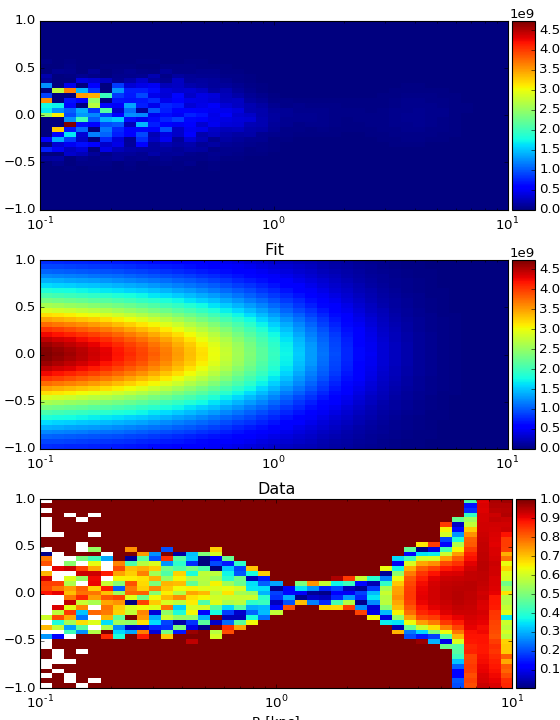

fit  : max = 2.842e+08, min = 1.823e+04
data : max = 4.728e+09, min = 1.056e+07


In [48]:
bins = gs_bins -1


edge = 20
zedge = edge/13.
x_gs = np.logspace(-0.5,np.log10(edge),bins)
y_gs = np.linspace(-zedge,zedge,bins)


x = np.logspace(-1,np.log10(10),bins)
y = np.linspace(-1,1,bins/2)

#x = np.logspace(-1,np.log10(25),bins)
#y = np.linspace(-6,6,(bins/2.5))
U= np.meshgrid(x_gs, y_gs)


"""
Z = gas(U[0],U[1],9.3, 0.2 , 1.2)
"""
#"""
Z = gas(U[0],U[1],mg2.values['D_0'], 0.5 , mg2.values['Rd'])
#"""



fig ,[ax,ax1,ax2] = plt.subplots(3,1,figsize=[7,9])


plt.tight_layout(h_pad=2)
ax.set_xscale('log')
real = ax.imshow(dens_hist_gs, interpolation='nearest', origin='low',aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')



ax1.set_title("Fit")
ax1.set_xscale('log')


fit = ax1.imshow(Z, interpolation='nearest', origin='low',aspect='auto',
                  extent=[x[0], x[-1], y[0], y[-1]])#,norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)

#ax.set_title("Data")

#real = ax.imshow(dens_hist, interpolation='nearest', origin='low',aspect='auto',
#                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')

print "fit  : max = {0:.3e}, min = {1:.3e}".format(Z.max(),Z.min())
print "data : max = {0:.3e}, min = {1:.3e}".format(dens_hist_gs.max(),dens_hist.min())
ratio =  np.abs(Z-dens_hist_gs)/dens_hist_gs

ax2.set_title("Data")
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax2.set_xscale('log')

real = ax2.imshow(ratio, interpolation='nearest', origin='low', vmax=1,aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmax=1e0))
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='data/fit')

In [47]:
#sf1 = m_rho_hydro
#sf0 = m_rho_hydro
#dmo = m_bin

<IPython.core.display.Javascript object>


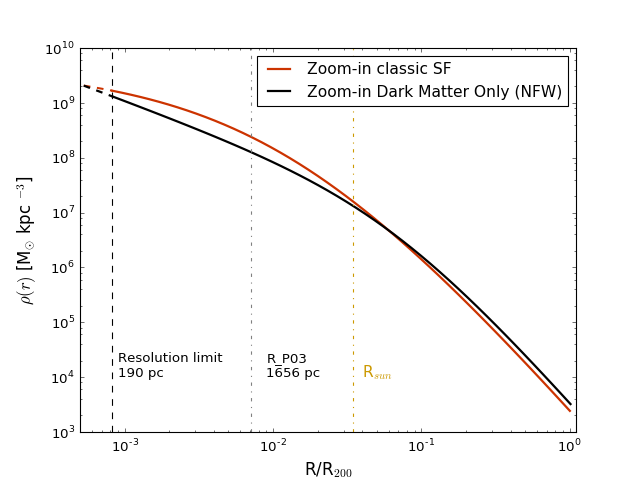

In [50]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([0.0005,1.1])
ax.set_ylim([1e3,1e10])
ax.set_xlabel(r'R/R$_{200}$',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)
r_in = np.logspace(-1,np.log10(myhydro.gs.hsml.min()))
r_out = np.logspace(np.log10(myhydro.gs.hsml.min()),np.log10(myhydro.r200))

## Hydro

ax.plot(r_in/myhydro.r200,(abg_profile(r_in,sf0.values['po'] ,sf0.values['r_s'],sf0.values['al'],sf0.values['be'],sf0.values['ga'])),
        color="#CC3300",ls="--",lw=1.8)
ax.plot(r_out/myhydro.r200,(abg_profile(r_out,sf0.values['po'] ,sf0.values['r_s'],sf0.values['al'],sf0.values['be'],sf0.values['ga'])),
        color="#CC3300",ls="-",lw=2,label = "Zoom-in classic SF")

## Hydro
"""
ax.plot(r_in/myhydro.r200,(abg_profile(r_in,sf1.values['po'] ,sf1.values['r_s'],sf1.values['al'],sf1.values['be'],sf1.values['ga'])),
        "b--",lw=1.8)
ax.plot(r_out/myhydro.r200,(abg_profile(r_out,sf1.values['po'] ,sf1.values['r_s'],sf1.values['al'],sf1.values['be'],sf1.values['ga'])),
        "b-",lw=2,label = "Zoom-in Turbulent SF")
"""
#DMO
ax.plot(r_in/myDMO.r200,(abg_profile(r_in,dmo.values['po'] ,dmo.values['r_s'],dmo.values['al'],dmo.values['be'],dmo.values['ga'])),
        "k--",lw=2)
ax.plot(r_out/myDMO.r200,(abg_profile(r_out,dmo.values['po'] ,dmo.values['r_s'],dmo.values['al'],dmo.values['be'],dmo.values['ga'])),
        "k-",lw=2,label = "Zoom-in Dark Matter Only (NFW)")


ax.axvline(myhydro.gs.hsml.min()/myhydro.r200,color="k",linestyle="--")
ax.text(9e-4,1e4,"Resolution limit\n190 pc")
ax.axvline(R_P03/myhydro.r200,color="gray",linestyle="-.")
ax.text(9e-3,1e4,"R_P03\n{0} pc".format(int(R_P03*1e3)))
ax.axvline(8/myhydro.r200,color="#CC9900",linestyle="-.")
ax.text(4e-2,1e4,r"R$_{sun}$",fontsize=14,color="#CC9900" )

legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()

In [ ]:
sf1.values


In [ ]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([0.005 ,200])
ax.set_ylim([1e3,1e10])
ax.set_xlabel(r'R/R$_{200}$',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)
r_in = np.logspace(-1,np.log10(myhydro.gs.hsml.min()))
r_out = np.logspace(np.log10(myhydro.gs.hsml.min()),np.log10(myhydro.r200))

## Hydro

ax.plot(r_in,(abg_profile(r_in,m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga'])),
        color="#660000",ls="--",lw=1.8)
ax.plot(r_out,(abg_profile(r_out,m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga'])),
     color="#660000",ls="-",lw=2,label = "Zoom-in classic SF")
"""
## Hydro

ax.plot(r_in,(abg_profile(r_in,sf1.values['po'] ,sf1.values['r_s'],sf1.values['al'],sf1.values['be'],sf1.values['ga'])),
        "b--",lw=1.8)
ax.plot(r_out,(abg_profile(r_out,sf1.values['po'] ,sf1.values['r_s'],sf1.values['al'],sf1.values['be'],sf1.values['ga'])),
        "b-",lw=2,label = "Zoom-in Turbulent SF")
"""
#DMO
ax.plot(r_in,(abg_profile(r_in,dmo.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])),
        "k--",lw=2)
ax.plot(r_out,(abg_profile(r_out,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])),
        "k-",lw=2,label = "Zoom-in Dark Matter Only")


ax.axvline(myhydro.gs.hsml.min()/myhydro.r200,color="k",linestyle="--")
ax.text(9e-4,1e4,"Resolution limit\n190 pc")
ax.axvline(R_P03/myhydro.r200,color="gray",linestyle="-.")
ax.text(8e-3,1e4,"R_P03\n{0} pc".format(int(R_P03*1e3)))

legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()